In [142]:
#!pip install pyro-ppl==1.5.2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)
torch.random.manual_seed(42)
pyro.set_rng_seed(42)
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [143]:
df = pd.read_csv("Data/cces_all_clean.csv")
states = pd.read_excel("Data/states.xlsx")
df.head()
states = states.rename(columns={'republican support percentage':"rep_sup"})
states.tail()

,states,rep_sup,region
45,VT,0.30,northeast
46,WA,0.36,west
47,WI,0.47,midwest
48,WV,0.68,southeast
49,WY,0.67,west


In [144]:
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    df[category+"_cat"] = df[category].astype('category').cat.codes
states["region"] = states["region"].astype('category').cat.codes

In [145]:
states

,states,rep_sup,region
0,AK,0.51,4
1,AL,0.62,2
2,AR,0.60,2
3,AZ,0.48,3
4,CA,0.31,4
5,CO,0.43,4
6,CT,0.40,1
7,DE,0.41,2
8,FL,0.49,2
9,GA,0.50,2


In [146]:
states_x = states.iloc[:,1:].values
states_x = torch.tensor(states_x).float()
#states

In [147]:
mat = df.iloc[:,6:].values
X = mat
X = torch.tensor(X).float()
y = df.iloc[:,0].values
y = torch.tensor(y).float()
print(X.shape)
print(states_x.shape)
print(y)

torch.Size([59810, 5])
torch.Size([50, 2])
tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [148]:
from torch import sigmoid
def model(X, states_x, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    ####################
    #alpha_state = pyro.sample("alpha_state", dist.Normal(torch.zeros(50), sigmas[6]))
    ####################
    
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X), subsample_size=1000) as ind:
        state = X[ind,0].tolist()
        eth = X[ind,1].tolist()
        male = X[ind,2].tolist()
        male_t = X[ind,2]
        age = X[ind,3].tolist()
        educ = X[ind,4].tolist()
        y = pyro.sample("y",dist.Bernoulli(sigmoid(gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age] + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] + beta_male*male_t)), obs= obs[ind])
    return y

In [149]:
"""
# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 6000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X,states_x,y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))
"""

[0] ELBO: 138197.4
[500] ELBO: 39851.5
[1000] ELBO: 40594.2
[1500] ELBO: 40210.5
[2000] ELBO: 40471.1
[2500] ELBO: 40279.8
[3000] ELBO: 40213.4
[3500] ELBO: 40065.5
[4000] ELBO: 40026.1
[4500] ELBO: 40361.2
[5000] ELBO: 39870.5
[5500] ELBO: 39927.4


In [150]:
#torch.save({"guide" : guide}, "mymodel.pt")
#pyro.get_param_store().save("mymodelparams.pt")

In [151]:
import numpyro
import numpyro.distributions as ndist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

def model2(X, obs=None):
    
    sigmas = numpyro.sample("sigmas", ndist.HalfCauchy(5.), sample_shape = (8,))
    gammas = numpyro.sample("gammas", ndist.Normal(0., 5.), sample_shape = (7,))
    alpha_educ = numpyro.sample("alpha_educ", ndist.Normal(0., sigmas[0]), sample_shape = (5,))
    alpha_eth = numpyro.sample("alpha_eth", ndist.Normal(0., sigmas[1]), sample_shape = (4,))
    alpha_age = numpyro.sample("alpha_age", ndist.Normal(0., sigmas[2]), sample_shape = (6,))
    alpha_male_eth = numpyro.sample("alpha_male_eth", ndist.Normal(0., sigmas[3]), sample_shape = (2,4))
    alpha_educ_age = numpyro.sample("alpha_educ_age", ndist.Normal(0., sigmas[4]), sample_shape = (5,6))
    alpha_educ_eth = numpyro.sample("alpha_educ_eth", ndist.Normal(0., sigmas[5]), sample_shape = (5,4))
    
    beta_male = numpyro.sample("beta_male", ndist.Normal(0.,5.))
    with numpyro.plate("data", size = len(X)):
        state = X[:,0].tolist()
        eth = X[:,1].tolist()
        male = X[:,2].tolist()
        male_t = X[:,2]
        age = X[:,3].tolist()
        educ = X[:,4].tolist()
        y = numpyro.sample("y", ndist.Bernoulli(jax.nn.sigmoid(gammas[5] + gammas[6]* jnp.array(states_x[:,0][state]) + gammas[jnp.array(states_x[:,1][state],dtype = int)]+ alpha_educ[jnp.array(educ, dtype = int)] + alpha_eth[jnp.array(eth, dtype = int)] + alpha_age[jnp.array(age, dtype = int)] + alpha_male_eth[jnp.array(male, dtype = int), jnp.array(eth, dtype = int)] + alpha_educ_age[jnp.array(educ, dtype = int), jnp.array(age, dtype = int)] + alpha_educ_eth[jnp.array(educ, dtype = int), jnp.array(eth, dtype = int)] + beta_male*jnp.array(male_t))), obs= obs)
        print(y.shape)
    return y

In [152]:
# Run inference in Pyro
"""
import time
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model2, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, X, y)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

# Show summary of inference results
mcmc.summary()
"""

'\nimport time\nimport jax\nimport jax.numpy as jnp\nfrom jax import random, vmap\nfrom jax.scipy.special import logsumexp\nfrom jax import lax\nt0 = time.time()\n\nrng_key = random.PRNGKey(0)\nrng_key, rng_key_ = random.split(rng_key)\n\nnuts_kernel = NUTS(model=model2, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)\nmcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)\nmcmc.run(rng_key_, X, y)\n\nt_fin = time.time()\n\nprint("Total time: {0:.3f}m".format((t_fin - t0)/60))\n\n# Show summary of inference results\nmcmc.summary()\n'

In [153]:
from pyro.infer import Predictive

saved_model_dict = torch.load("mymodel.pt")
guide = saved_model_dict['guide']
pyro.get_param_store().load("mymodelparams.pt")

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha_educ", "alpha_eth", "alpha_age", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "gammas", "y","data"))
samples = predictive(X,states_x, y)

In [154]:
print(samples.keys())

dict_keys(['gammas', 'alpha_educ', 'alpha_eth', 'alpha_age', 'alpha_male_eth', 'alpha_educ_age', 'alpha_educ_eth', 'beta_male', 'y'])


In [155]:
params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
params_samples = {}
for param in params:
    params_samples[param] = samples[param].detach().numpy()

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/kuba/anac

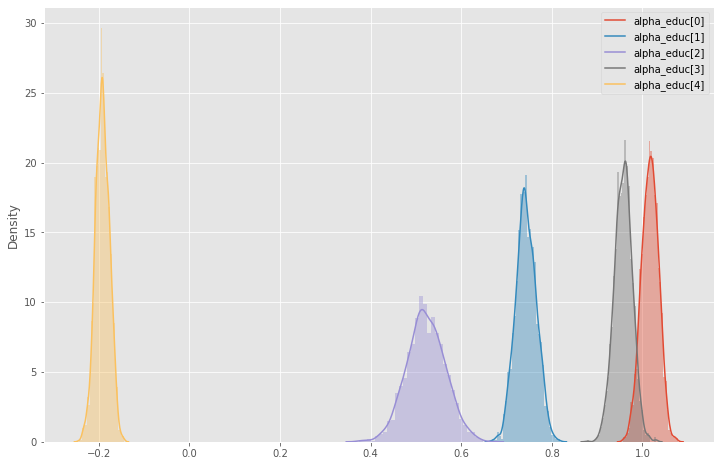

In [156]:
n_cat = 5
for c in range(n_cat):
    sns.distplot(params_samples["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show()

In [157]:
#n_cat = 50
#for c in range(n_cat):
#    sns.distplot(params_samples["alpha_state"][:,c])
#plt.legend(["alpha_state[%d]" % c for c in range(n_cat)])
#plt.show()

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



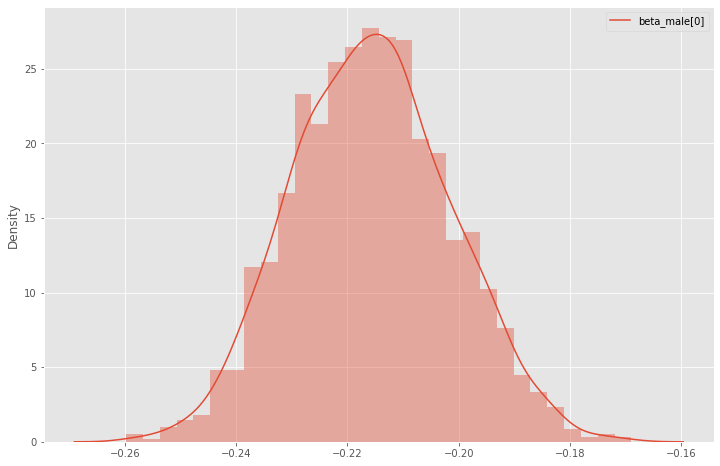

In [158]:
n_cat = 1
for c in range(n_cat):
    sns.distplot(params_samples["beta_male"][:,c])
plt.legend(["beta_male[%d]" % c for c in range(n_cat)])
plt.show()

In [159]:
# extract expected values of the parameters
params_hat = {}
for param in params:
    params_hat[param] = samples[param].mean(axis=0).detach().numpy()
#params_hat

In [160]:
# make predictions for the train set
def sigmoid_n(x):
    x = x.numpy()
    return 1 / (1 + np.exp(-x))
state = X[:,0].int().tolist()
eth = X[:,1].int().tolist()
male = X[:,2].int().tolist()
male_t = X[:,2].numpy()
age = X[:,3].int().tolist()
educ = X[:,4].int().tolist()
y_hat = np.round(sigmoid_n(params_hat["gammas"][5]+ params_hat["gammas"][6]* states_x[:,0][state]+ params_hat["gammas"][states_x[:,1][state].int().tolist()] +params_hat["alpha_educ"][educ]+ params_hat["alpha_eth"][eth] + params_hat["alpha_age"][age] + params_hat["alpha_male_eth"][male, eth] + params_hat["alpha_educ_age"][educ, age] + params_hat["alpha_educ_eth"][educ, eth] +params_hat["beta_male"]*male_t))
y_true = y.numpy()
print("predictions:", y_hat)
print("true values:", y_true)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))

predictions: [0. 1. 0. ... 0. 0. 0.]
true values: [1. 1. 1. ... 0. 0. 0.]
Accuracy: 0.5972579836147801


# Guessing zeros everywhere: (Baseline)

In [161]:
np.sum(np.zeros(len(y_true)) == y_true)/len(y_true)

0.5658418324694867

# Logistic regression

# POSTSTRATIFICATION

In [162]:
post = pd.read_csv("Data/poststrat_df.csv")
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    post[category+"_cat"] = post[category].astype('category').cat.codes
post

,state,eth,male,age,educ,n,state_cat,eth_cat,male_cat,age_cat,educ_cat
0,AL,White,-0.5,18-29,No HS,23948,1,3,0,0,2
1,AL,White,-0.5,18-29,HS,59378,1,3,0,0,1
2,AL,White,-0.5,18-29,Some college,104855,1,3,0,0,4
3,AL,White,-0.5,18-29,4-Year College,37066,1,3,0,0,0
4,AL,White,-0.5,18-29,Post-grad,9378,1,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
11995,WY,Hispanic,0.5,70+,No HS,293,49,1,1,5,2
11996,WY,Hispanic,0.5,70+,HS,284,49,1,1,5,1
11997,WY,Hispanic,0.5,70+,Some college,191,49,1,1,5,4
11998,WY,Hispanic,0.5,70+,4-Year College,75,49,1,1,5,0


In [163]:
states_x_n = states_x.numpy()

In [164]:
import math
from tqdm.notebook import tqdm
def sigmoid_n(x):
    return 1 / (1 + np.exp(-x))

In [165]:
gammas = params_samples["gammas"]
theta = 0
for state_i in tqdm(range(50)):
    for eth_i, eth in enumerate(params_samples["alpha_eth"].T):
        for age_i, age in enumerate(params_samples["alpha_age"].T):
            for educ_i, educ in enumerate(params_samples["alpha_educ"].T):
                for male_i in [0,1]:
                    theta_sub = sigmoid_n(gammas[:, 5] + gammas[:,6]* states_x_n[:,0][state_i] + gammas[:,int(states_x_n[:,1][state_i])] + educ + eth + age + params_samples["alpha_educ_age"][:,educ_i,age_i] + params_samples["alpha_educ_eth"][:,educ_i,eth_i]+params_samples["beta_male"].squeeze()*male_i)
                    theta += theta_sub *  post[(post["state_cat"] == state_i) & (post["age_cat"] == age_i) & (post["eth_cat"] == eth_i) & (post["educ_cat"] == educ_i) & (post["male_cat"] == male_i)]["n"].values[0]
theta = theta / post["n"].sum()

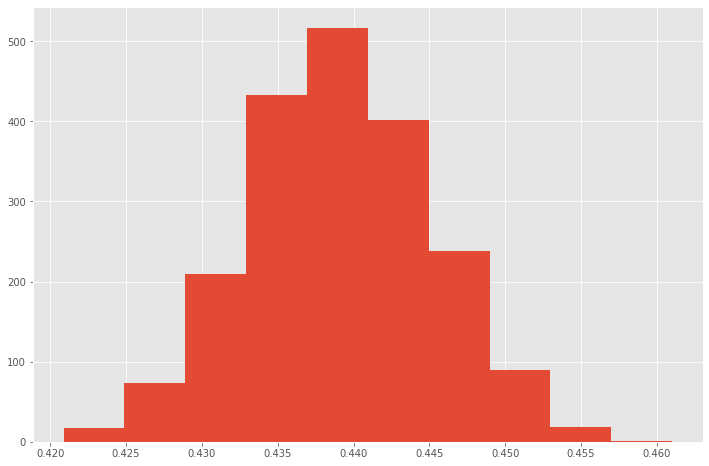

In [166]:
plt.hist(theta);
plt.show();

In [167]:
print("Survey mean support: ", y_true.sum()/len(y_true))
print("Survey support std: ", math.sqrt(y_true.mean()*(1-y_true.mean())/len(y_true)))
print("Size of the Survey:  ", len(y_true))
print("")
print("MRP mean support estimate: ", theta.mean())
print("MRP std: ", theta.std())
print("Population size: ", post["n"].sum())



Survey mean support:  0.4341581675305133
Survey support std:  0.002026677347449802
Size of the Survey:   59810

MRP mean support estimate:  0.439098122791906
MRP std:  0.006071075387526488
Population size:  228443347


In [168]:
#!pip install -q geopandas==0.3.0
#!pip install -q pyshp==1.2.10
#!pip install -q shapely==1.6.3
#!pip install -q plotly-geo

In [169]:
import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=states["states"], # Spatial coordinates
    z = np.arange(50).astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Support %",
))

fig.update_layout(
    title_text = '2016 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()